## Data Import and Check

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import stats
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
import matplotlib.gridspec as gridspec

* I import data and drop duplicates
* I had tried to set the user id as index. Expectedly, it did not work as a user can have multiple trips. However the user - trip combination did not work either which revealed the entire rows duplicated
* Once the duplicates are removed, the count of use -trip combinations reveal they constitute a unique key

In [5]:
hoppi = pd.read_csv('C:/Users/gurkaali/Documents/Info/Ben/Hop/WatchesTable.csv', sep=",")
hoppi.drop_duplicates(inplace = True)
hoppi.groupby(['user_id', 'trip_id'])['user_id']\
    .count() \
    .reset_index(name='count')\
    .sort_values(['count'], ascending = False)\
    .head(5)

,user_id,trip_id,count
0,0000047cef6f4f75ca2dc57d4777932d3de4dcf6593da9...,6b0011957e76e00ef2fb704f01b64a7efbf4b066f2c78f...,1
528870,aaaa396bf8e4c82215bc0da4a0d3180de6df39e8870e52...,63f0102387c3d37278f9270c9495092e7d5db78d5c6ceb...,1
528896,aaabacacacfc88c7d9395d1202e5e32b678deb3de95b04...,e3fdd12f5e92499ebce67d366ce5667b43f562c7a06fd0...,1
528897,aaac33395341a9ce53d71cd32e12f028aeb790cff33a1e...,4cdb917e6d862e14a917c79af145408d0a8f020197d7b3...,1
528898,aaac67f43edd9784492db54e94291d02ee5b560002373a...,f9ace867825d0677161ca549f85856a346c803fe5ef24a...,1


Now that I am sure, I can set the index:

In [6]:
hoppi.set_index(['user_id', 'trip_id'], inplace = True)

Pandas has great features for date calculations. I set the related field types as datetime in case I need those features

In [7]:
hoppi['departure_date'] = pd.to_datetime(hoppi['departure_date'], format = '%m/%d/%y')
hoppi['return_date'] = pd.to_datetime(hoppi['return_date'], format = '%m/%d/%y')
hoppi['first_search_dt'] = pd.to_datetime(hoppi['first_search_dt'], format = '%m/%d/%y %H:%M')
hoppi['watch_added_dt'] = pd.to_datetime(hoppi['watch_added_dt'], format = '%m/%d/%y %H:%M')
hoppi['latest_status_change_dt'] = pd.to_datetime(hoppi['latest_status_change_dt'], format = '%m/%d/%y %H:%M')
hoppi['first_buy_dt'] = pd.to_datetime(hoppi['first_buy_dt'], format = '%m/%d/%y %H:%M')
hoppi['last_notif_dt'] = pd.to_datetime(hoppi['last_notif_dt'], format = '%m/%d/%y %H:%M')
hoppi['forecast_last_warning_date'] = pd.to_datetime(hoppi['forecast_last_warning_date'], format = '%m/%d/%y')
hoppi['forecast_last_danger_date'] = pd.to_datetime(hoppi['forecast_last_danger_date'], format = '%m/%d/%y')

The explanations in the assignment do not cover all fields but field names and the content enable further data verification
* Stay should be the difference between departure and return dates. Based on that assumption, the query below should return no records i.e. the 1st item in the tuple returned by shape should be 0:

In [8]:
hoppi['stay2'] = pd.to_timedelta(hoppi['stay'], unit = 'D')
hoppi['stay_check'] = hoppi['return_date'] - hoppi['departure_date']
hoppi.loc[(hoppi['stay_check'] != hoppi['stay2']) & (hoppi['return_date'].isnull() == False), \
          ['stay2', 'stay_check', 'return_date', 'departure_date']].shape

(0, 4)

The following date fields must not be before the first search date. Therefore the queries below should reveal no records
* watch_added_dt
* latest_status_change_dt
* first_buy_dt
* last_notif_dt
* forecast_last_warning_date
* forecast_last_danger_date

In [9]:
hoppi.loc[(hoppi['watch_added_dt'] < hoppi['first_search_dt']), ['first_search_dt', 'watch_added_dt']].shape

(0, 2)

In [10]:
hoppi.loc[(hoppi['latest_status_change_dt'] < hoppi['first_search_dt']), ['first_search_dt', 'latest_status_change_dt']].shape

(0, 2)

33 records have a first buy suggestion datetime earlier  than the user's first search.

In [11]:
hoppi.loc[(hoppi['first_buy_dt'] < hoppi['first_search_dt']), ['first_search_dt', 'first_buy_dt']].shape

(33, 2)

While the difference is just minutes in most cases, I don't have an explanation to justify it. Given the limited number of cases, I prefer removing them

In [12]:
hoppi.loc[(hoppi['first_buy_dt'] < hoppi['first_search_dt']), ['first_search_dt', 'first_buy_dt']].head()

,,first_search_dt,first_buy_dt
user_id,trip_id,,
51e70b0f6be23fd0432be4a2fdca86516658ca8de670071d478928e6684c1c78,2fa595790a14db833a002826401217479ca0a8b11ee571e3cb15089b51843fb5,2018-02-24 13:08:00,2018-02-24 13:07:00
b0248efd5b45fd2d393768130954abab22591d1afb82d7e913fc86305309b965,c3845c3c663d03bc98fc12768f7e361cfe05042a1511834b78ec1e618220e67a,2018-04-02 14:17:00,2018-04-02 13:55:00
96cb9cc4b0f6915e5f7068a31c04be9511ba9e540bbbb2d9d63a4615188de350,8bad186fe0a1b5955c33155314d1455be4c733bd1a850c3dc73f2087c8a4e04d,2018-01-18 19:31:00,2018-01-18 19:23:00
d0dd26a1de70cc8f855aabadd3bb12626a7b6a0530f256f0ebdaab21f27dd406,037ffa5aa9258a4e4ff69871b2b14d958545c3e661d425d3d8ec27655ab009dd,2018-01-16 12:41:00,2018-01-16 12:35:00
d8db8a8decded09d9e4056d50b63bfd7a3b634d717a32e17b31069e7dba5048b,70f0639b959b452db6ff8be86cb9516612d5d3e54445b212b8c041c44124ccac,2018-01-04 10:15:00,2018-01-04 10:14:00


In [13]:
hoppi = hoppi.loc[~(hoppi['first_buy_dt'] < hoppi['first_search_dt'])]

There are also 2 records where the last notification is done before the user's first search. I remove those as well

In [14]:
hoppi.loc[(hoppi['last_notif_dt'] < hoppi['first_search_dt']), ['first_search_dt', 'last_notif_dt']]

first_search_dt  \
user_id                                            trip_id                                                                  
8a47f379d1db19111c8a7a68b51b6f22788f36dc59aa370... 6664669b137c239944f9cb75807f00fafbd5004ff702ebe... 2018-04-08 23:40:00   
                                                   44603020c2874f74701bae07f8a06ead0c5a62901da5342... 2018-04-08 23:40:00   

                                                                                                            last_notif_dt  
user_id                                            trip_id                                                                 
8a47f379d1db19111c8a7a68b51b6f22788f36dc59aa370... 6664669b137c239944f9cb75807f00fafbd5004ff702ebe... 2018-04-08 07:26:00  
                                                   44603020c2874f74701bae07f8a06ead0c5a62901da5342... 2018-04-08 07:27:00

In [15]:
hoppi = hoppi.loc[~(hoppi['last_notif_dt'] < hoppi['first_search_dt'])]

Same checks on last warning and last danger dates show 362K + and 98K + suspicious records. As the quantitiy is large and descriptions sent with the assignment do not contain details on these 2 fields, I prefer to keep them while taking a note here in case something provides with additional argument to delete them during analyses.

In [16]:
hoppi.loc[(hoppi['forecast_last_warning_date'] < hoppi['first_search_dt']), \
          ['first_search_dt', 'forecast_last_warning_date']].shape

(362212, 2)

In [17]:
hoppi.loc[(hoppi['forecast_last_danger_date'] < hoppi['first_search_dt']), \
          ['first_search_dt', 'forecast_last_danger_date']].shape

(98452, 2)

### Check outliers

I reshape the columns in a way that will make working with seaborn easier:

In [49]:
hoppi_box_components = [hoppi[['first_advance']].assign(measurement_type = 'first_advance').reset_index(). \
                        rename(columns = {'first_advance': 'measurement'}),
                        hoppi[['watch_advance']].assign(measurement_type = 'watch_advance').reset_index(). \
                        rename(columns = {'watch_advance': 'measurement'}),
                        hoppi[['current_advance']].assign(measurement_type = 'current_advance').reset_index(). \
                        rename(columns = {'current_advance': 'measurement'})]
hoppi_box = pd.concat(hoppi_box_components)

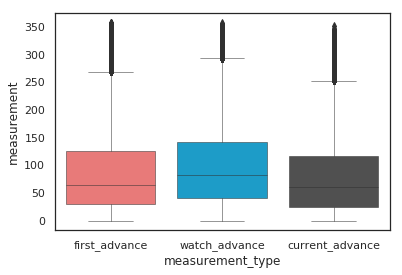

In [50]:
sns.set(font = 'DejaVu Sans', style = 'white')
ax = sns.boxplot(x="measurement_type", y="measurement",
                 data=hoppi_box, palette=["#FA6866", "#01AAE4", "#505050"], #Hopper colors
                linewidth = 0.5)

While several observations look like outliers on the boxplots, the histograms below show that the data is highly skewed. Therefore I do not consider them as outliers

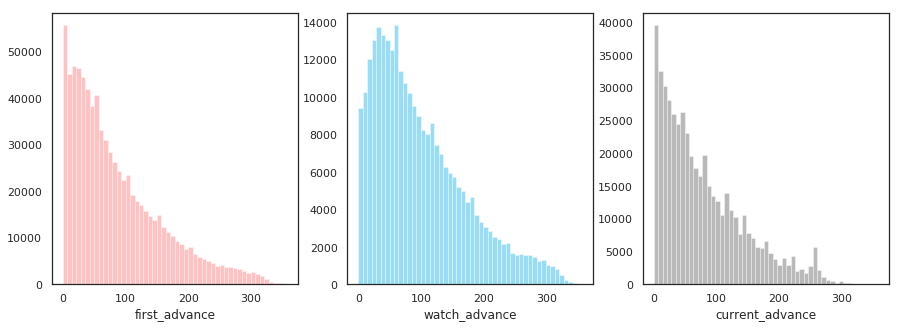

In [51]:
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
sns.distplot(hoppi['first_advance'], kde=False, color="#FA6866", ax=axes[0])
sns.distplot(hoppi.loc[hoppi['watch_advance'].isnull() == False, 'watch_advance'], kde=False, color="#01AAE4", ax=axes[1])
sns.distplot(hoppi.loc[hoppi['current_advance'].isnull() == False, 'current_advance'], kde=False, color="#505050", ax=axes[2])

### Question 1

Given the business model of Hopper, we should understand who is more likely to buy a ticket eventually. Logistic Regression constitutes a convenient way of conducting such analysis. It runs faster than SVN and is easier to interpret, making it ideal for a task like this one:

I prepare categorical variables for trip types:

In [18]:
one_hot_trip_type = pd.get_dummies(hoppi['trip_type'])
hoppi2 = hoppi.join(one_hot_trip_type)

I believe the city / airport distinction in origin and destination fields refer to the fact that some airports are more central such as the difference between Toronto Billy Bishop and Pearson airports. I also checked some airport codes, they do corresponds to cities where there are multiple airports with one or more being city airports

In [19]:
origin_cols = hoppi2['origin'].str.split("/", n = 1, expand = True) 
hoppi2['origin_code'] = origin_cols[1]
hoppi2['origin_type'] = origin_cols[0]

destination_cols = hoppi2['destination'].str.split("/", n = 1, expand = True) 
hoppi2['destination_code'] = destination_cols[1]
hoppi2['destination_type'] = destination_cols[0]

In [20]:
one_hot_destination_type = pd.get_dummies(hoppi2['destination_type'])
hoppi3 = hoppi2.join(one_hot_destination_type)
hoppi3.rename(columns={"airport": "destination_airport", "city": "destination_city"}, inplace = True)

In [21]:
one_hot_origin_type = pd.get_dummies(hoppi3['origin_type'])
hoppi4 = hoppi3.join(one_hot_origin_type)
hoppi4.rename(columns={"airport": "origin_airport", "city": "origin_city"}, inplace = True)

I prepare categorical variables for whether a watch is placed or not:

In [22]:
hoppi4.loc[hoppi3['watch_added_dt'].isnull() == True, 'watch_bin'] = 0
hoppi4.loc[hoppi3['watch_added_dt'].isnull() == False, 'watch_bin'] = 1

Given the user - trip combination being unique across the data file, we do not have information on the changes for a user who has updated his trip status. As the data looks like covering the last status of a trip, I prefer to focus analyses on concluded queries i.e. trips either expired or booked. I exclude:
* actives: because their result is yet to be seen. The user can end up booking before departure
* shopped: because a user can make several searches on the same itinerary with alternative options each ending up as a new record in the database. I consider a search once the suer starts following the trip price
* inactive: because some have departure in the future so their result cannot be concluded. I also exclude those with departure in the past as it falls in the same category as the shopped trips as the user stopped following the trip.
I assign a new column for records I take into account in my analyses further below:

In [23]:
hoppi4.loc[hoppi3['status_latest'] == 'expired', 'result'] = 0
hoppi4.loc[hoppi3['status_latest'] == 'booked', 'result'] = 1

A person might be prompted to buy once the price falls because it makes sense or maybe he buys as soon as it starts increasing to avoid further increase. Whatever the case, it makes sense to compare the price at different time points with respect to the original price at first search. For that, I create columns to measure price difference between the last price, the first time a buy recommended, the lowest price vs the the very first price:

In [24]:
hoppi4['dif_last_first'] = hoppi4['last_total'] - hoppi4['first_total']
hoppi4['dif_buy_first'] = hoppi4['first_buy_total'] - hoppi4['first_total']
hoppi4['dif_lowest_first'] = hoppi4['lowest_total'] - hoppi4['first_total']

I create a categorical variable for the last recommendation as well to check whether a buy recommendation makes user to book:

In [25]:
one_hot_last_rec = pd.get_dummies(hoppi4['last_rec']) # this create s 2 columns: buy and wait
hoppi5 = hoppi4.join(one_hot_last_rec)
hoppi5.loc[hoppi5['last_rec'].isnull(), 'buy'] = np.nan # originally null values are given 0. I undo that manipulation here

I make a table with rows containing certain results that I want to focus on i.e. expired and booked

In [26]:
hoppi6 = hoppi5.loc[hoppi5['result'].isnull() == False, 
          ['round_trip', 
        'destination_city', 'origin_city',
        'weekend',
       'filter_no_lcc', 'filter_non_stop', 'filter_short_layover', 'status_updates', 
        'watch_bin', 'total_notifs', 'total_buy_notifs', 'buy',
       'dif_last_first', 'dif_buy_first', 'dif_lowest_first', 'first_advance', 'result']]
hoppi6.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 45237 entries, (e42e7c15cde08c19905ee12200fad7cb5af36d1fe3a3310b5f94f95c47ae51cd, 05d59806e67fa9a5b2747bc1b24842189bba0c45e49d3714549fc5df9838ed20) to (d414b1c72a16512dbd7b3859c9c9f574633578acef74d120490625d9010103c7, 3a363a2456b6b7605347e06d2879162b3008004370f73a68f52523330ccd38a6)
Data columns (total 17 columns):
round_trip              45237 non-null uint8
destination_city        45237 non-null uint8
origin_city             45237 non-null uint8
weekend                 45237 non-null int64
filter_no_lcc           45237 non-null int64
filter_non_stop         45237 non-null int64
filter_short_layover    45237 non-null int64
status_updates          45237 non-null int64
watch_bin               45237 non-null float64
total_notifs            44800 non-null float64
total_buy_notifs        44800 non-null float64
buy                     44800 non-null float64
dif_last_first          44800 non-null float64
dif_buy_first           44133 non-null

Some rows have null values such as the price difference between the buy moment and the first price as some users may not have gt the buy recommendation yet. To cover these features, I get only non-null rows:

In [74]:
df = hoppi6.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 44133 entries, (e42e7c15cde08c19905ee12200fad7cb5af36d1fe3a3310b5f94f95c47ae51cd, 05d59806e67fa9a5b2747bc1b24842189bba0c45e49d3714549fc5df9838ed20) to (d414b1c72a16512dbd7b3859c9c9f574633578acef74d120490625d9010103c7, 3a363a2456b6b7605347e06d2879162b3008004370f73a68f52523330ccd38a6)
Data columns (total 17 columns):
round_trip              44133 non-null uint8
destination_city        44133 non-null uint8
origin_city             44133 non-null uint8
weekend                 44133 non-null int64
filter_no_lcc           44133 non-null int64
filter_non_stop         44133 non-null int64
filter_short_layover    44133 non-null int64
status_updates          44133 non-null int64
watch_bin               44133 non-null float64
total_notifs            44133 non-null float64
total_buy_notifs        44133 non-null float64
buy                     44133 non-null float64
dif_last_first          44133 non-null float64
dif_buy_first           44133 non-null

In [75]:
X = df[['round_trip', 
        'destination_city', 'origin_city',
        'weekend',
       'filter_non_stop', 'filter_short_layover', 'status_updates', 'filter_no_lcc', 
        'watch_bin', 'total_notifs', 'buy', 'total_buy_notifs', 
       'dif_lowest_first',
        'dif_last_first', 
        'dif_buy_first', 
        'first_advance']] 
y = df['result']
print(X.shape, y.shape)

(44133, 16) (44133,)


In [76]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=1)
logit_model=sm.Logit(y_train, X_train)
result=logit_model.fit(maxiter = 1000)
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.041569
         Iterations 12
                           Results: Logit
Model:                Logit              Pseudo R-squared:   0.852   
Dependent Variable:   result             AIC:                765.7809
Date:                 2019-06-20 12:20   BIC:                879.1482
No. Observations:     8826               Log-Likelihood:     -366.89 
Df Model:             15                 LL-Null:            -2484.6 
Df Residuals:         8810               LLR p-value:        0.0000  
Converged:            1.0000             Scale:              1.0000  
No. Iterations:       12.0000                                        
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
round_trip           -0.7625   0.2318  -3.2898 0.0010 -1.2167 -0.3082
destination_cit

In [44]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

C:\ProgramData\Anaconda3\envs\operational\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [45]:
accuracy_score(y_test, y_pred)

0.9880760189197609

In [46]:
sum(y_train)/len(y_train)

0.08112395196011783

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     32564
         1.0       0.97      0.87      0.92      2743

   micro avg       0.99      0.99      0.99     35307
   macro avg       0.98      0.93      0.96     35307
weighted avg       0.99      0.99      0.99     35307



#### Data driven insights:
The model shows a good level of accuracy. However given the imbalance of data (only 8% of data corresponds to an actual booking) it is crucial to check recall which also shows a high value i.e. false negatives are limited.
Now that we know the model looks robust, we can make the following data-driven insights:
1. City travelers, regardless their origin and destination, are not necessarily more likely to end up booking. These are the people likely to be business travelers. When we look at the weekend travelers which I use as a substitute as pleasure travelers, people are significantly more likely to end up booking. It looks like people are more sensitive to buy recommendations when it is a personal travel
2. Among filters, only those who filter for short layover are more likely to book whereas the significance is not as powerfull (at a p = 0.10 level)
3. Buy recommendations significantly impact booking behavior which indicates that the algorithm makes sense to the customer
4. Price fluctuations have significant impact on users' booking behavior:
    * The lowest and first price difference is significant with a positive relationship with the booking behavior showing that people are more likely to buy when there is a price drop after their first query
    * When the last price or the price of the buy recommendation are higher than the first price, users are less likely to book.
    * The above 2 points show that the algorithm leads to the expected user behavior.
5. Those who sign up for a price watch are more likely to book. This feature might be an indicator that the user is seriously making a plan. To be concrete, someone who is looking at options for a dream vacation in case he wins the lottery would not be setting the watch on whereas someone who took days off at work next month would do so.

### Question 2

#### Most "watched" itineraries

I would like to see the watch selected cases w.r.t. the itinerary i.e. NY to MTL would be considered the same as MTL to NY

In [77]:
hoppi5.loc[(hoppi5['watch_bin'] == 1.0) & (hoppi5['result'] == 0)].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 40873 entries, (e42e7c15cde08c19905ee12200fad7cb5af36d1fe3a3310b5f94f95c47ae51cd, 05d59806e67fa9a5b2747bc1b24842189bba0c45e49d3714549fc5df9838ed20) to (d414b1c72a16512dbd7b3859c9c9f574633578acef74d120490625d9010103c7, 3a363a2456b6b7605347e06d2879162b3008004370f73a68f52523330ccd38a6)
Data columns (total 58 columns):
trip_type                      40873 non-null object
origin                         40873 non-null object
destination                    40873 non-null object
departure_date                 40873 non-null datetime64[ns]
return_date                    34064 non-null datetime64[ns]
stay                           34064 non-null float64
weekend                        40873 non-null int64
filter_no_lcc                  40873 non-null int64
filter_non_stop                40873 non-null int64
filter_short_layover           40873 non-null int64
filter_name                    40873 non-null object
status_updates                 40873 

In [78]:
pareto_watch_0 = hoppi5.loc[(hoppi5['watch_bin'] == 1.0) & (hoppi5['result'] == 0.0), ['origin_code', 'destination_code']]
pareto_watch_0.loc[pareto_watch_0['origin_code'] < pareto_watch_0['destination_code'], \
                   'itinerary'] = \
                    pareto_watch_0['origin_code'] + pareto_watch_0['destination_code']
pareto_watch_0.loc[pareto_watch_0['origin_code'] > pareto_watch_0['destination_code'], \
                   'itinerary'] = \
                    pareto_watch_0['destination_code'] + pareto_watch_0['origin_code']

In [79]:
pareto_watch_0.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 40873 entries, (e42e7c15cde08c19905ee12200fad7cb5af36d1fe3a3310b5f94f95c47ae51cd, 05d59806e67fa9a5b2747bc1b24842189bba0c45e49d3714549fc5df9838ed20) to (d414b1c72a16512dbd7b3859c9c9f574633578acef74d120490625d9010103c7, 3a363a2456b6b7605347e06d2879162b3008004370f73a68f52523330ccd38a6)
Data columns (total 3 columns):
origin_code         40873 non-null object
destination_code    40873 non-null object
itinerary           40873 non-null object
dtypes: object(3)
memory usage: 39.9+ MB


In [81]:
pareto_watch = pareto_watch_0 \
                .groupby(['itinerary']) \
                .size().reset_index() \
                .rename(columns = {0: 'count'}) \
                .sort_values(['count'], ascending = False)

In [82]:
pareto_watch.set_index('itinerary', inplace = True)
pareto_watch['cumulative_sum'] = pareto_watch['count'].cumsum()
pareto_watch['cumulative_perc'] = 100 * pareto_watch['cumulative_sum'] / pareto_watch['count'].sum()

In [86]:
pareto_watch.loc[pareto_watch['cumulative_perc'] <= 80].shape[0]
pareto_watch.shape[0]
print('All observations where the user watched the price but did not book, cover ',
      pareto_watch.shape[0],
      'itineraries. Out of these,  ',
      pareto_watch.loc[pareto_watch['cumulative_perc'] <= 80].shape[0],
      ' constitute 80% of the whole observation set. That is around ',
     round(100 * pareto_watch.loc[pareto_watch['cumulative_perc'] <= 80].shape[0] / pareto_watch.shape[0], 1),
     '% of the whole set.')

All observations where the user watched the price but did not book, cover  11697 itineraries. Out of these,   4236  constitute 80% of the whole observation set. That is around  36.2 % of the whole set.


The list gives the biggest airports. This result reassures that it is additionally critical to make reliable estimations for these itineraries. The top 10 itineraries consist only of US destinations showing the importance of the US market. As we have seen in the previous question, a user setting the watch on is a good estimator of an actual booking. Therefore accuracy of price estimations is extra important for the US market. This information could be handy for the data scientists developing algorithms e.g. they can give extra weight to the accuracy of US flights

#### Watch vs the Moment the First Search is Done

* Here I am looking whether there is significant difference between users with a watch and without in terms of the following two:
    * the first price found 
    * the number of days left to departure as of first search

In [89]:
dfw = hoppi5.loc[hoppi5['result'].isnull() == False, ['first_advance', 'first_total', 'watch_bin', 'result']]
dfw = dfw.dropna()

In [92]:
dfw.groupby('watch_bin').agg({'first_advance': np.mean, 'first_total': np.mean})

,first_advance,first_total
watch_bin,,
0.0,41.008651,298.630025
1.0,33.891864,425.278487


* As the data is skewed using non-parametrical tests makes more sense. I use the Mann Whitney test for that purpose
* The test reveal significant difference between watched and non-watched itineraries at 0.1 level in terms of the number of days between the departure and the first search. Those who place a watch have a week less time left to their departure compared to the rest. Users may be using hopper as an assistant when they feel like they missed the time window where they could shop for different offers. For those users more frequent notifications can be planned

In [56]:
stat, p = mannwhitneyu(dfw.loc[dfw['watch_bin'] == 1, 'first_advance'], 
                       dfw.loc[dfw['watch_bin'] == 0, 'first_advance'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=41274130.000, p=0.074


* The test on same user groups (those watching vs those who don't) show that they differ in terms of the price they get at their first search. The difference is highly significant given the p-value. 
* Those who watch have a trip cost of USD125 more on average.
* There might be a growth opportunity in budget passengers. When the user makes a first search which reveals a relatively cheap price, Hopper can suggest watching for the same trip with additional services such as business class. If that suggesiton can be supported with a statement like "business flights for this flight can get as close as $X to the economy fares, why don't you watch?" the user can be convinced to shop for more.

In [57]:
stat, p = mannwhitneyu(dfw.loc[dfw['watch_bin'] == 1, 'first_total'], 
                       dfw.loc[dfw['watch_bin'] == 0, 'first_total'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=29810391.000, p=0.000


### Question 3

Chart 1: What is the situation as of now compared to PY?
* Note that from the current advance field in the data, I see that we are on April 10th 2018
* Expired: Watch is on + Current Date > Departure Date
* Inactive: Watch is off + Current Date can be before or after Current Date
* Active: Watch is on + Current Date <= Departure Date
* Shopped: Watch is on or off + Current Date can be before or after Current Date; the latter of first search and watch date added is equal to the latest_status_change
* Booked: 

#### Chart 1: Number of Incoming / Outgoing / Converted Searches Through Time

On a daily basis, I'd like to see the number of 
* new searches of trips (incoming), 
* end of validity trips i.e. trips with departure date passing by
* converted searches i.e. booked trips

<br>
Ideally I would like to see the number for these for a given day / time window as well as for the same period prior year (more on this in Q4). howeveer the data covers first searches over a period from 2018 start to April 10th. For illustrative purposes I show the count of the 2 KPIs above throughout the year

It is good practive to create date range and join data onto that as the data source may not have data for every day:

In [97]:
date_range = pd.date_range(start='1/1/2018', end='04/10/2018', freq='D')
df_date = pd.DataFrame(date_range, columns = ['date_range'])
df_date.set_index('date_range', inplace = True)

incoming traffic counts the number of first time searches each day:

In [98]:
hoppi5['first_search_dt_dateonly'] = hoppi5['first_search_dt'].dt.date
incoming_traffic = hoppi5.groupby(['first_search_dt_dateonly']) \
                .size().reset_index() \
                .rename(columns = {0: 'count'}) 
incoming_traffic.set_index('first_search_dt_dateonly', inplace = True)

outgoing traffic counts the number of trips with departure within the same day, each day. Until a trip is considered 'outgoing' there is a chance that it can be converted to booking:

In [99]:
outgoing_traffic = hoppi5.groupby(['departure_date']) \
                .size().reset_index() \
                .rename(columns = {0: 'count'}) 
outgoing_traffic.set_index('departure_date', inplace = True)

converted traffic is the numbe rof bookings that took place each day i.e. conversions:

In [100]:
hoppi5['latest_status_change_dt_dateonly'] = hoppi5['first_search_dt'].dt.date
converted_traffic = hoppi5.loc[hoppi5['status_latest'] == 'booked'].groupby(['latest_status_change_dt_dateonly']) \
                .size().reset_index() \
                .rename(columns = {0: 'count'}) 
converted_traffic.set_index('latest_status_change_dt_dateonly', inplace = True)

I join counts on the date range index created above:

In [101]:
df_chart1 = pd.merge(df_date, incoming_traffic, left_index = True, right_index = True, how='left')
df_chart1.rename(columns = {'count': 'incoming_count'}, inplace = True)
df_chart2 = pd.merge(df_chart1, outgoing_traffic, left_index = True, right_index = True, how='left')
df_chart2.rename(columns = {'count': 'outgoing_count'}, inplace = True)
df_chart3 = pd.merge(df_chart2, converted_traffic, left_index = True, right_index = True, how='left')
df_chart3.rename(columns = {'count': 'converted_count'}, inplace = True)
df_chart3['day'] = df_chart3.index.dayofyear

In [102]:
df_chart3_components = [df_chart3[['incoming_count', 'day']].assign(count_type = 'incoming').reset_index(). \
                        rename(columns = {'incoming_count': 'count'}),
                     df_chart3[['outgoing_count', 'day']].assign(count_type = 'outgoing').reset_index(). \
                        rename(columns = {'outgoing_count': 'count'}),
                     df_chart3[['converted_count', 'day']].assign(count_type = 'converted').reset_index(). \
                        rename(columns = {'converted_count': 'count'})]
df_chart4 = pd.concat(df_chart3_components)

I plot the chart here below. Note that the data collection seems to have started as of 2018 start. Therefore the outgoing count do not reflect the reality in the early periods of the chart. Also the number of trips whose departure is in the future at a given time could be shown as well. That would show the pool of trips that could be converted at a given time.

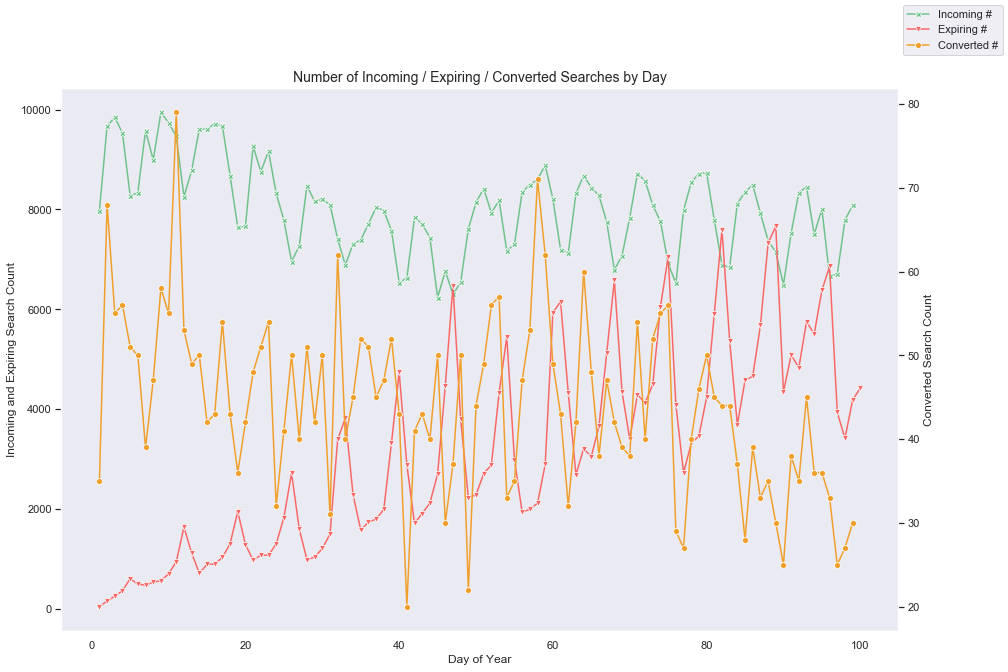

In [109]:
sns.set_style('dark')
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
sns.lineplot(x=df_chart3['day'], 
             y=df_chart3['incoming_count'],
             color='#6FC28B',
             marker = "X",
             ax=ax1)
sns.lineplot(x=df_chart3['day'], 
             y=df_chart3['outgoing_count'],
             color='#FA6866',
             marker="v",
             ax=ax1)
sns.lineplot(x=df_chart3['day'], 
             y=df_chart3['converted_count'],
             color='#F0A02A',
             marker="o",
             ax=ax2)
fig.legend(['Incoming #', 'Expiring #', 'Converted #'])
ax1.set(xlabel='Day of Year', ylabel='Incoming and Expiring Search Count')
ax2.set(ylabel='Converted Search Count')
plt.title('Number of Incoming / Expiring / Converted Searches by Day', fontsize = 14)
plt.show()

### Chart 2: KPIs Affecting Conversion - Categorical KPIs

Categorical variables that turned out to have an impact on conversion are worth following daily. As I sugegsted for the 1st chart, it makes more sense to compare these with prior year same period figures.
In this chart we follow the % of people who
* look for a round trip
* look for a weekend trip
* look for a short layover
* have an ongoing watch
* have an received a buy suggestion

<br>
Note that these are all categories that help estimate conversion

In [117]:
df_chart_perc1 = hoppi5.loc[hoppi5['departure_date'] >= '04-10-2018'].describe() # describe() gives the mean per vcategory. 
# As they were binary, it gives the %
df_chart_perc2 = df_chart_perc1.loc[['mean'], ['round_trip', 'weekend', 'filter_short_layover', 'watch_bin', 'buy']]
df_chart_perc2 = df_chart_perc2.transpose().reset_index() # transpose to make it convenient for seaborn notation
df_chart_perc2['mean'] = df_chart_perc2['mean'] * 100 # percentages in absolute numbers
df_chart_perc2.rename(columns = {'mean':'percentage'}, inplace=True)

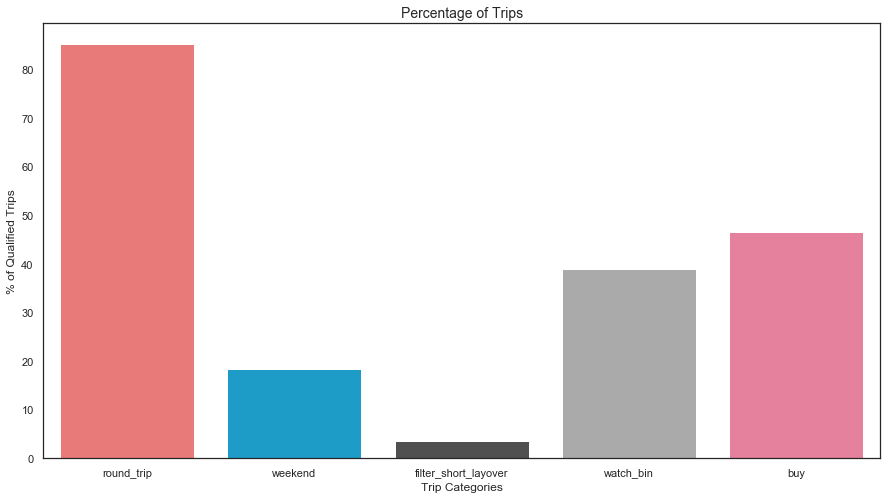

In [137]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(x="index",
            y="percentage", 
            palette=["#FA6866", "#01AAE4", "#505050", "#AAAAAA", "#F67096"],
            data=df_chart_perc2,
            ax=ax)
ax.set(xlabel='Trip Categories', ylabel='% of Qualified Trips')
plt.title("Percentage of Trips",fontsize=14)
plt.show()

### Chart 3: KPIs Affecting Conversion - Ordinal KPIs

In a similar vein to the Chart2, I look at KPIs having an impact on conversion here as well. This time I check ordinal variables. Again, it would make more sense to compare with prior year same period figures.
In this chart we follow 
* average difference between the lowest price found and the first price
* average difference between the last price and the first price
* average difference between the price when a buy recommendation was made and the first price
* average number of days between the first search and the departure date

<br>
Note that these are all categories that help estimate conversion as well.

In [138]:
df_chart_abs1 = hoppi5.loc[hoppi5['departure_date'] >= '04-10-2018'].describe()
df_chart_abs2 = df_chart_abs1.loc[['mean'], ['dif_lowest_first',
                                             'dif_last_first', 'dif_buy_first',
                                            'first_advance']]
df_chart_abs3 = df_chart_abs2.transpose().reset_index()
df_chart_abs3.rename(columns = {'mean':'average'}, inplace=True)

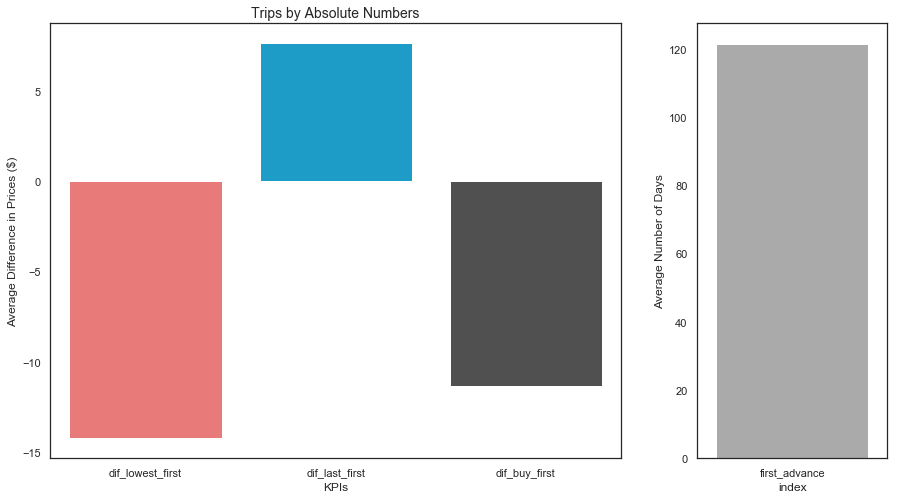

In [148]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(15,8))

sns.barplot(x=df_chart_abs3.loc[df_chart_abs3['index'] != 'first_advance']['index'], 
             y=df_chart_abs3.loc[df_chart_abs3['index'] != 'first_advance']['average'],
             palette=["#FA6866", "#01AAE4", "#505050"],
             ax=ax1)
sns.barplot(x=df_chart_abs3.loc[df_chart_abs3['index'] == 'first_advance']['index'], 
             y=df_chart_abs3.loc[df_chart_abs3['index'] == 'first_advance']['average'],
             color='#AAAAAA',
             ax=ax2)
ax1.set(xlabel='KPIs', ylabel='Average Difference in Prices ($)')
ax2.set(ylabel='Average Number of Days')
ax1.set_title('Trips by Absolute Numbers', fontsize = 14)
plt.show()

### Question 4

* I should have the history on every trip - user. That would enable insight in 2 main fields:
    * Communication Strategy: Recording of every update related to a user - trip allows:
        * to understand after how many notifications...
            * a booking takes place
            * a watch is canceled
        * Year on Year (YoY) comparisons: A record with active status now could have been inactive at a certain point of time as the user can enable / disable watch at different times. As a result, a YoY comparison of records in terms of their statuses is not possible with the information in hand
* I would also like to have this data for a longer period to identify returning customers, frequent flyers for whom I could develop new features